In [1]:
!pip install pandas torch transformers scikit-learn datasets seaborn matplotlib accelerate openpyxl

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np

In [4]:
# --- MEMUAT DATA HASIL AUGMENTASI DAN PREPROCESSING ---
print("--- MEMUAT DATA YANG SUDAH DI-AUGMENTASI ---")
input_filename = '../Data/hasil_preprocessed_augmented.csv'
try:
    df = pd.read_csv(input_filename)
    df.dropna(subset=['Teks_Stemmed'], inplace=True)
    df = df[df['Teks_Stemmed'].str.strip() != '']
    print(f"File '{input_filename}' berhasil dibaca. Jumlah data: {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{input_filename}' tidak ditemukan.")
    exit()

--- MEMUAT DATA YANG SUDAH DI-AUGMENTASI ---
File '../Data/hasil_preprocessed_augmented.csv' berhasil dibaca. Jumlah data: 164 baris.


In [5]:
# --- PERSIAPAN DAN PEMBAGIAN DATA ---
print("\n--- PERSIAPAN DAN PEMBAGIAN DATA ---")
labels = sorted(df['Sentimen'].unique())
label_map = {label: i for i, label in enumerate(labels)}
df['label'] = df['Sentimen'].map(label_map)

X = df['Teks_Stemmed']
y = df['Sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data dibagi menjadi: {len(X_train)} data latih dan {len(X_test)} data uji.")
print("\nDistribusi Sentimen pada Data Uji:")
print(y_test.value_counts())


--- PERSIAPAN DAN PEMBAGIAN DATA ---
Data dibagi menjadi: 131 data latih dan 33 data uji.

Distribusi Sentimen pada Data Uji:
Sentimen
positif    17
negatif    10
netral      6
Name: count, dtype: int64


In [6]:
# ==============================================================================
# --- TAHAP MODEL KLASIK TF-IDF DAN LOGISTIC REGRESSION ---
# ==============================================================================
print("\n\n--- MEMULAI TAHAP MODEL TF-IDF DAN LOGISTIC REGRESSION (DATA AUGMENTASI) ---")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
logreg_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logreg_model.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg_model.predict(X_test_tfidf)
print("Model Logistic Regression berhasil dilatih ulang dan dievaluasi.")



--- MEMULAI TAHAP MODEL TF-IDF DAN LOGISTIC REGRESSION (DATA AUGMENTASI) ---
Model Logistic Regression berhasil dilatih ulang dan dievaluasi.


In [7]:
# ==============================================================================
# --- TAHAP MODEL INDOBERT ---
# ==============================================================================
print("\n\n--- MEMULAI TAHAP MODEL INDOBERT ---")
train_df_bert = pd.DataFrame({'Teks_Stemmed': X_train, 'label': y_train.map(label_map)})
test_df_bert = pd.DataFrame({'Teks_Stemmed': X_test, 'label': y_test.map(label_map)})
train_dataset = Dataset.from_pandas(train_df_bert)
test_dataset = Dataset.from_pandas(test_df_bert)

model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)



--- MEMULAI TAHAP MODEL INDOBERT ---


In [8]:
def tokenize_function(examples):
    return tokenizer(examples['Teks_Stemmed'], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

training_args = TrainingArguments(
    output_dir='./results_augmented',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir='./logs_augmented',
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="steps",
    save_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("\nMemulai proses fine-tuning IndoBERT dengan data augmentasi...")
trainer.train()
print("Pelatihan IndoBERT selesai.")

predictions_bert = trainer.predict(test_dataset)
y_pred_indices_bert = np.argmax(predictions_bert.predictions, axis=1)
y_pred_bert = [labels[i] for i in y_pred_indices_bert]
y_true_bert = test_df_bert['label'].map({v: k for k, v in label_map.items()}).tolist()

Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Memulai proses fine-tuning IndoBERT dengan data augmentasi...


C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss
10,1.034300,1.056681
20,0.662300,0.912057
30,0.663000,1.141223
40,0.612000,1.045969
50,0.561000,0.925351


C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Pelatihan IndoBERT selesai.


C:\Users\Wede\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)




--- HASIL PERBANDINGAN PERFORMA MODEL SETELAH AUGMENTASI ---

--- 1. Hasil Evaluasi Model TF-IDF dan Logistic Regression ---
Akurasi Model: 66.67%

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.60      0.60      0.60        10
      netral       1.00      0.50      0.67         6
     positif       0.65      0.76      0.70        17

    accuracy                           0.67        33
   macro avg       0.75      0.62      0.66        33
weighted avg       0.70      0.67      0.67        33


--- 2. Hasil Evaluasi Model IndoBERT ---
Akurasi Model: 66.67%

Laporan Klasifikasi:
              precision    recall  f1-score   support

     negatif       0.54      0.70      0.61        10
      netral       1.00      0.17      0.29         6
     positif       0.74      0.82      0.78        17

    accuracy                           0.67        33
   macro avg       0.76      0.56      0.56        33
weighted avg       0.72      0.67   

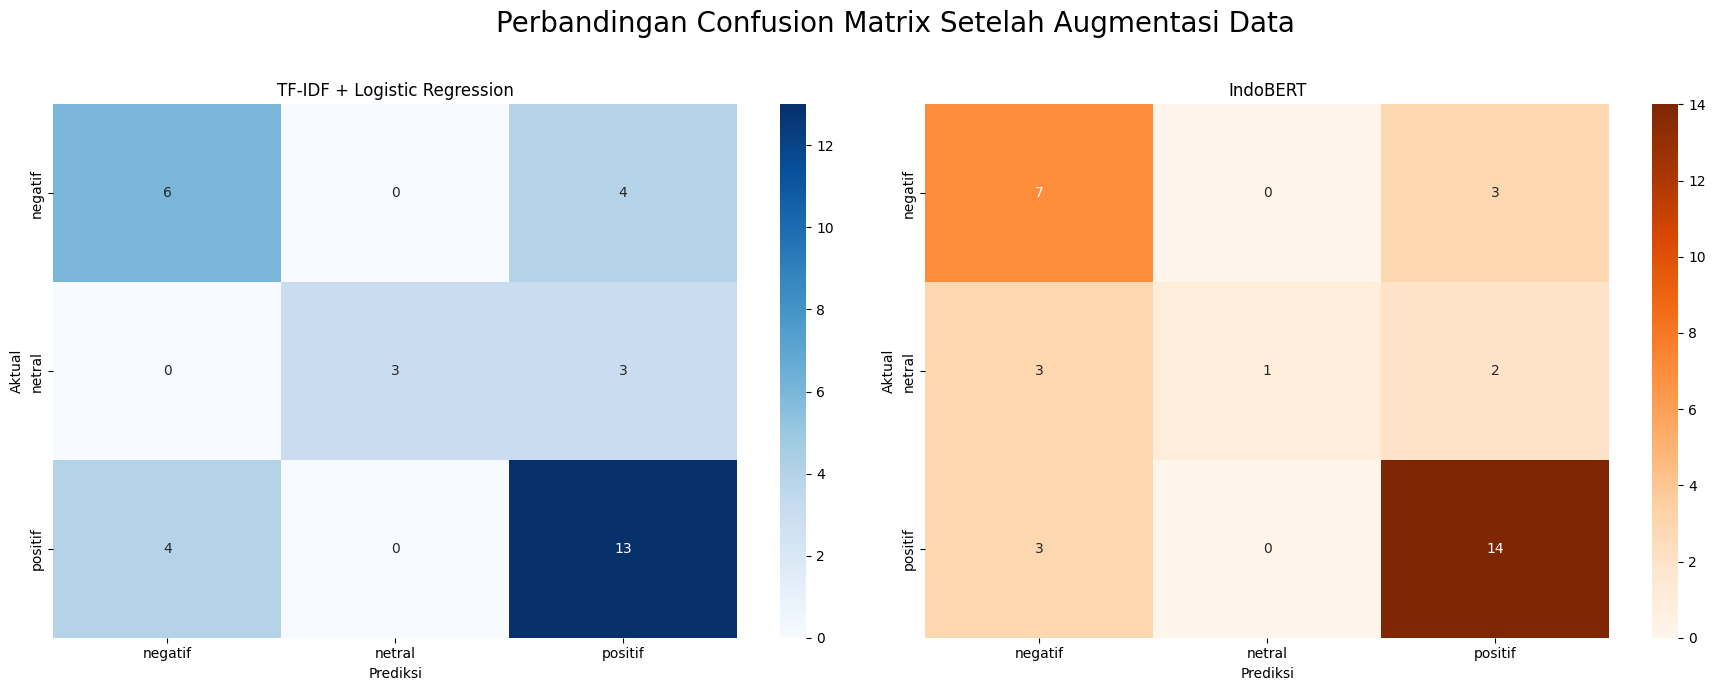


✅ Seluruh proses proyek selesai. Anda telah berhasil membandingkan model pada data yang diseimbangkan.


In [9]:
print("\n\n--- HASIL PERBANDINGAN PERFORMA MODEL SETELAH AUGMENTASI ---")

# --- Hasil Model TF-IDF dan Logistic Regression ---
print("\n--- 1. Hasil Evaluasi Model TF-IDF dan Logistic Regression ---")
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Akurasi Model: {accuracy_logreg:.2%}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred_logreg, labels=labels, zero_division=0))

# --- Hasil Model IndoBERT ---
print("\n--- 2. Hasil Evaluasi Model IndoBERT ---")
accuracy_bert = accuracy_score(y_true_bert, y_pred_bert)
print(f"Akurasi Model: {accuracy_bert:.2%}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_true_bert, y_pred_bert, labels=labels, zero_division=0))

# --- Visualisasi Confusion Matrix Berdampingan ---
print("\nMembuat visualisasi perbandingan Confusion Matrix...")
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Perbandingan Confusion Matrix Setelah Augmentasi Data', fontsize=20)

cm_logreg = confusion_matrix(y_test, y_pred_logreg, labels=labels)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('TF-IDF + Logistic Regression')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Aktual')

cm_bert = confusion_matrix(y_test, y_pred_bert, labels=labels)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('IndoBERT')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Aktual')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n✅ Seluruh proses proyek selesai. Anda telah berhasil membandingkan model pada data yang diseimbangkan.")